In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

operating_system = 'mac'

if operating_system == 'win':
    os.chdir('C:/Users/fabau/OneDrive/Documents/GitHub/master-project-cleaned/')
elif operating_system == 'curnagl':
    os.chdir('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/cleaner_version/')
else:
    os.chdir('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/')

# Add the path to the custom library
custom_library_path = os.path.abspath('util/processing/')
sys.path.append(custom_library_path)

import extraction_squares

if operating_system == 'curnagl':
    name_of_variable= pd.read_csv('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/DATASETS/variable_list_80_mean.csv')
    path_data = '/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/DATASETS'
else:
    name_of_variable= pd.read_csv('data/variable_list_80_mean.csv')
    path_data = 'data'

storm_dates = pd.read_csv('pre_processing/tracks/storm_dates.csv')
path_tracks_1h = 'pre_processing/tracks/ALL_TRACKS/tracks_1h'
#path_tracks_1h_non_EU = 'pre_processing/tracks/ALL_TRACKS/tracks_1h_non_EU'
dataset = 'datasets_1h'
#dataset_non_EU = 'datasets_1h_non_EU'

In [2]:
X_train, X_test, X_validation, y_train, y_test, y_validation, X_all_3d, y_all_3d = extraction_squares.X_y_datasets_EU(name_of_variable, storm_dates, path_data, path_tracks_1h, dataset, False)

Shape of the X 3D ndarray: (96, 472, 316)
Shape of the y 3D ndarray: (96, 472, 4)
Storm Training: [ 0  2  3  4  5  6  7 11 12 13 14 16 17 18 19 20 21 22 23 24 25 27 28 29
 31 34 35 36 37 38 39 40 42 43 44 46 47 48 50 53 54 56 57 58 61 64 66 69
 70 71 73 75 76 77 78 79 81 82 83 85 86 87 88 90 92 93 94 95]
Storm Test: [ 1  9 10 15 26 33 52 59 60 62 63 68 74 84]
Storm Valid: [ 8 30 32 41 45 49 51 55 65 67 72 80 89 91]
Order of the stats : 'max', 'min', 'mean', 'std'


In [3]:
# reshape the X_training into a 2D array

X_all_2d = X_train.reshape(X_train.shape[0]*X_train.shape[1],X_train.shape[2])
# same for y_all_3d
y_all_2d = y_train.reshape(y_train.shape[0]*y_train.shape[1],y_train.shape[2])

# drop all the rows with nan values

X_all_2d = pd.DataFrame(X_all_2d)
X_all_2d_non_na = X_all_2d.dropna()
y_all_2d = pd.DataFrame(y_all_2d)
y_all_2d_non_na = y_all_2d.dropna()

# rename the columns by the name of the variables by adding also the stat of the variable (max, min, mean, std)

stats = ['max', 'min', 'mean', 'std']
var_stat = []
var_stat_all = []

for var in name_of_variable['variables']:
    for stat in stats:
        var_stat = f'{var}_{stat}'
        var_stat_all.append(var_stat)

# drop instantaneous variables, u and v wind components

var_stat_all_x = [var for var in var_stat_all if 'inst' not in var]
instantaneous = ['instantaneous_10m_wind_gust_max', 'instantaneous_10m_wind_gust_min', 'instantaneous_10m_wind_gust_mean', 'instantaneous_10m_wind_gust_std']

X_all_2d_non_na.columns = var_stat_all_x
y_all_2d_non_na.columns = instantaneous

y_mean = y_all_2d_non_na.drop(columns=['instantaneous_10m_wind_gust_max', 'instantaneous_10m_wind_gust_min', 'instantaneous_10m_wind_gust_std'])
y_max = y_all_2d_non_na.drop(columns=['instantaneous_10m_wind_gust_min', 'instantaneous_10m_wind_gust_mean', 'instantaneous_10m_wind_gust_std'])

In [8]:
# drop columns with 10m_u_component_of_wind and 10m_v_component_of_wind variables

X_all_2d_non_na = X_all_2d_non_na.drop(columns=['10m_u_component_of_wind_max', 
                                                '10m_u_component_of_wind_min', 
                                                '10m_u_component_of_wind_mean', 
                                                '10m_u_component_of_wind_std', 
                                                '10m_v_component_of_wind_max', 
                                                '10m_v_component_of_wind_min', 
                                                '10m_v_component_of_wind_mean', 
                                                '10m_v_component_of_wind_std'])

var_stat_all_x = [var for var in var_stat_all_x if '10m' not in var]

/Users/fabienaugsburger/anaconda3/envs/master/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


Text(0.5, 1.0, 'Correlation matrix for all variables')

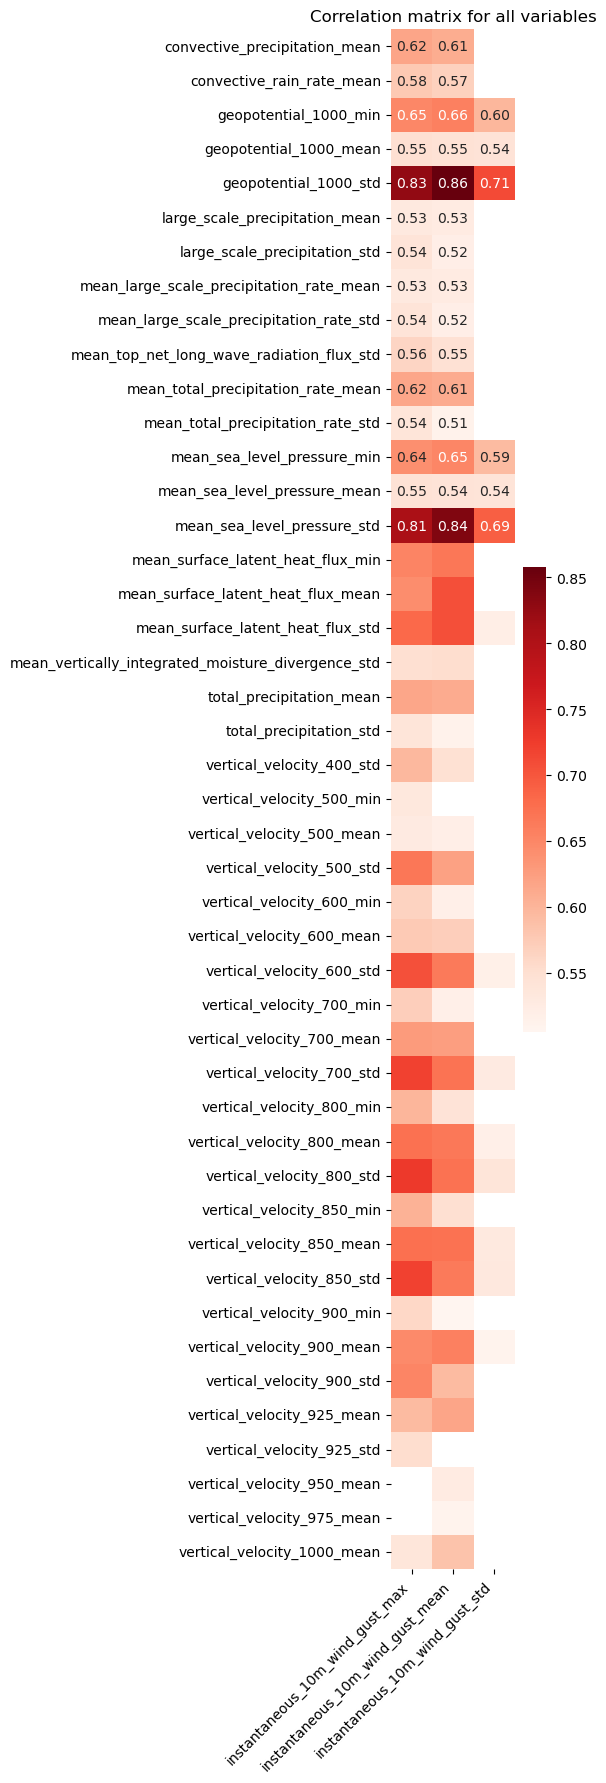

In [9]:
# combine the X and y datasets

all_data = pd.concat([X_all_2d_non_na, y_all_2d_non_na], axis=1)

# create the correlation matrix

corr_matrix = all_data.corr()
corr_matrix_abs = abs(corr_matrix)
#corr_inst = corr_matrix_abs.iloc[-4:, :-4]
corr_inst = corr_matrix_abs.iloc[:-4, -4:]
#corr_inst = corr_inst.iloc[:, :-4]
corr_inst_sel_05 = corr_inst[corr_inst > 0.5]

# change remaining nan values to 0
#corr_inst_sel_05 = corr_inst_sel_05.fillna(0)

# remove the columns with rows full of nan values
corr_inst_sel_05 = corr_inst_sel_05.dropna(axis = 0, how = 'all')

corr_inst_sel_05 = corr_inst_sel_05.drop(columns='instantaneous_10m_wind_gust_min')

# create a heatmap correlation matrix with all the variables but per statistic
#corr_matrix_abs = abs(corr_inst_sel_05)
plt.figure(figsize=(2, 20))
sns.heatmap(corr_inst_sel_05, annot=True, cmap='Reds', fmt=".2f")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title(f'Correlation matrix for all variables')

In [10]:
# select the var that are above 0.5 correlation with the instantaneous max and mean

corr_inst_max = corr_inst_sel_05[corr_inst_sel_05['instantaneous_10m_wind_gust_max'] > 0.5]
corr_inst_max = corr_inst_max.drop(columns='instantaneous_10m_wind_gust_mean')
corr_inst_max = corr_inst_max.drop(columns='instantaneous_10m_wind_gust_std')
corr_inst_mean = corr_inst_sel_05[corr_inst_sel_05['instantaneous_10m_wind_gust_mean'] > 0.5]
corr_inst_mean = corr_inst_mean.drop(columns='instantaneous_10m_wind_gust_max')
corr_inst_mean = corr_inst_mean.drop(columns='instantaneous_10m_wind_gust_std')

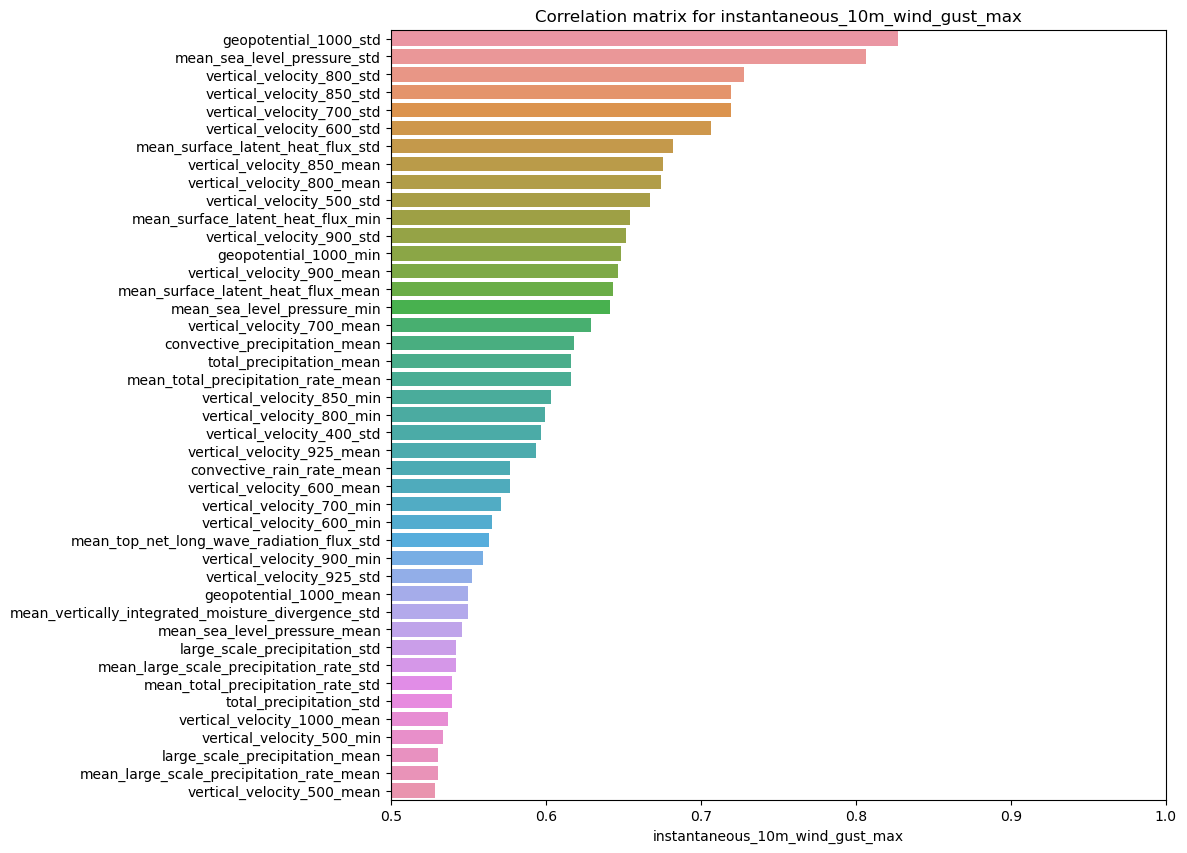

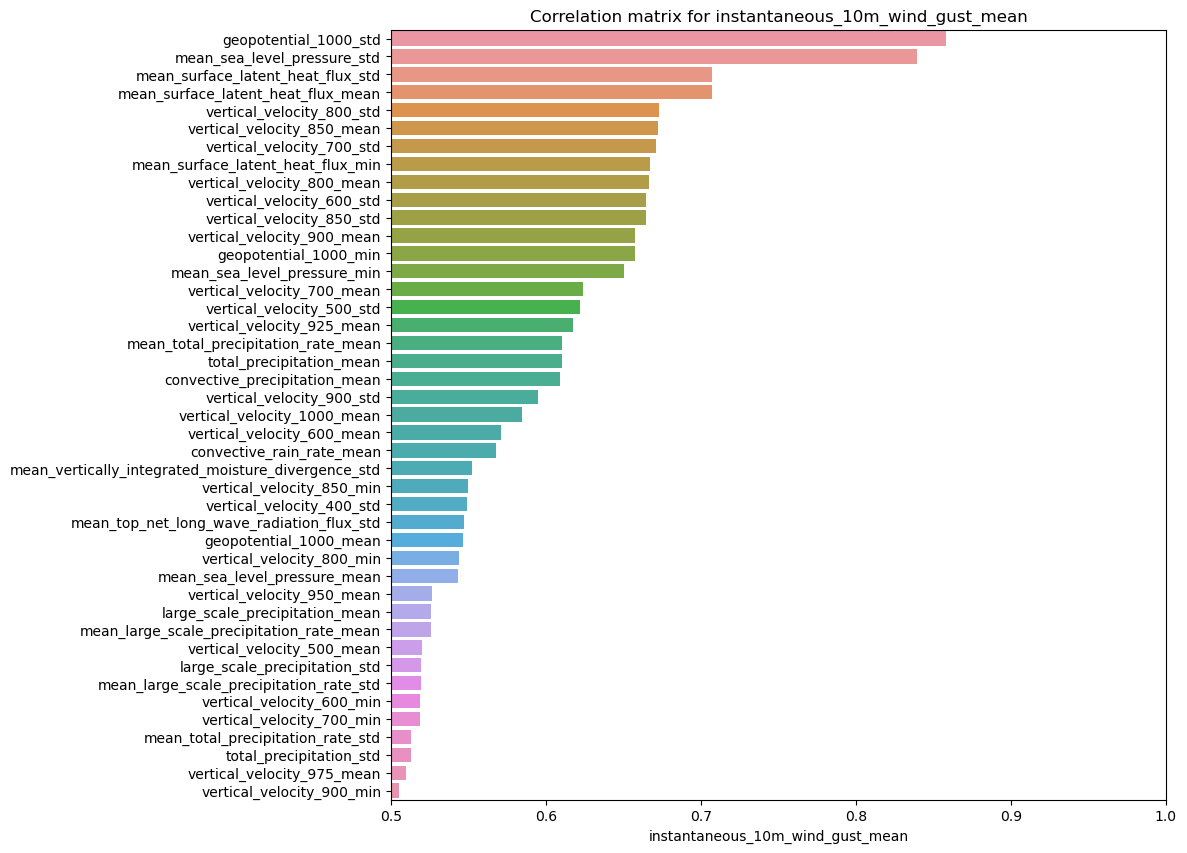

In [11]:
# Sort the data by correlation
sorted_corr_max = corr_inst_max.sort_values(by='instantaneous_10m_wind_gust_max', ascending=False)

# Plot with sorted data
plt.figure(figsize=(10, 10))
sns.barplot(
    x=sorted_corr_max['instantaneous_10m_wind_gust_max'], 
    y=sorted_corr_max.index, 
    order=sorted_corr_max.index
)
plt.title('Correlation matrix for instantaneous_10m_wind_gust_max')
plt.xlim(0.5, 1)
plt.show()

# Sort the data by correlation
sorted_corr_mean = corr_inst_mean.sort_values(by='instantaneous_10m_wind_gust_mean', ascending=False)

# Plot with sorted data
plt.figure(figsize=(10, 10))
sns.barplot(
    x=sorted_corr_mean['instantaneous_10m_wind_gust_mean'], 
    y=sorted_corr_mean.index, 
    order=sorted_corr_mean.index
)
plt.title('Correlation matrix for instantaneous_10m_wind_gust_mean')
plt.xlim(0.5, 1)
plt.show()